# 现在数据 计算蒙特卡洛方程f

In [1]:
import os
import xarray as xr
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.ndimage import distance_transform_edt

In [2]:
# 插值统一seddata和agedata
seddata = xr.open_dataset(r'data2411\Globsed-v3.nc')
lon = np.arange(-180,180.25,0.25)
lat = np.arange(-90,90.25,0.25) # 分辨率为15分
'''
lon = seddata.lon 
lat = seddata.lat #分辨率为5分 
'''
seddata = seddata.rename({'z':'sed'})
sed_interp = seddata.interp(lon = lon, lat = lat, method = 'linear')
agedata = xr.open_dataset(r'data2411\PresentDayAge.nc')
age_interp = agedata.interp(lon = lon, lat = lat, method = 'linear') # 用scipy，griddata插值
age_interp = age_interp.rename({'z':'age'})

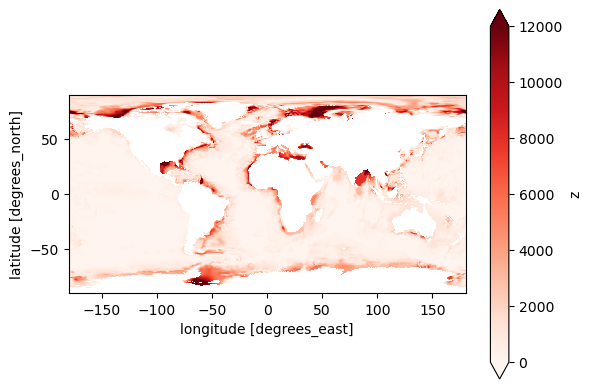

In [3]:
# 绘制现在sed数据
sed_interp.sed.plot(cmap = 'Reds', vmin = 0, vmax = 12000, add_colorbar = True)
ax = plt.gca()
ax.set_aspect(1)
# age_interp.age.plot()#add_colorbar = False)
plt.show()

In [4]:
# 合并到一个dataset，并将lat加入变量
merged = xr.merge([sed_interp, age_interp])
merged.attrs.clear()
'''
merged['var_lon'] = merged['lat']  
merged.set_index(['lon', 'lat'], append=True, inplace=True)
'''
merged['var_lat'] = merged['lat'] + merged['lon']*0 # im good

In [5]:
# 计算距离，加入merged dataset
mask_now = xr.open_dataset(r'landmask.nc')
# 来自黑框 gmt grdlandmask -R-180/180/-90/90 -I0.25 -A0/0/1 -N1/0 -Di -Glandmask.nc
# 海陆蒙版landmask，海洋为1，大陆为0
numpy_mask = mask_now.z.values 
distances = distance_transform_edt(numpy_mask) 
merged['distance'] = xr.DataArray(data = distances, 
                                  dims = ('lat','lon'), 
                                  coords = {'lon':merged['lon'], 'lat':merged['lat']})

# 随机森林

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
# 2. 数据集分割
sed = merged.sed.values.reshape(-1)
var_lat = merged.var_lat.values.reshape(1, -1)
age = merged.age.values.reshape(1, -1)
distance = merged.distance.values.reshape(1, -1)
X = np.vstack((var_lat, age, distance)).T # xlat_age_d
Y = sed # ysed

masky = ~np.isnan(Y)  # 创建掩码，过滤掉 NaN 值
X = X[masky]
Y = Y[masky]
maskx = ~np.isnan(X).any(axis=1)  # 检查每行是否存在 NaN
X = X[maskx]  # 保留没有 NaN 的行
Y = Y[maskx]  # 保持 Y 和 X 行一致
print(np.isnan(Y).sum())  # 检查 Y 中的 NaN 数量
print(np.isnan(X).sum())  # X 中 NaN

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

0
0


In [31]:
# 3. 构建随机森林回归模型
print("Training Random Forest Model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)  # 初始化随机森林回归器
for _ in tqdm(range(1), desc="Model Training"):
    model.fit(X_train, y_train)  # 在训练集上训练模型

# 4. 测试模型
y_pred = model.predict(X_test)  # 在测试集上预测目标值
mse = mean_squared_error(y_test, y_pred)  # 计算均方误差
print(f"Mean Squared Error: {mse:.4f}")  # 输出模型性能

Training Random Forest Model...


Model Training: 100%|███████████████████████████████████████████████████████████████████| 1/1 [02:28<00:00, 148.65s/it]


Mean Squared Error: 133570.9645


In [32]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 365.4736


In [33]:
sed_test = model.predict(X)
sed_iterx = iter(sed_test)  # 将sed_test 转换为迭代器
sed_re = [next(sed_iterx) if x else np.nan for x in maskx]  # 根据 maskx 的值决定是否填充
sed_itery = iter(sed_re)
sed_re = [next(sed_itery) if x else np.nan for x in masky]
sed_re = np.array(sed_re).reshape(len(lat), len(lon))
print(sed_re)

[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 ...
 [2328.48037354 2329.48376465 2330.23394287 ... 2313.35405029
  2320.05897217 2328.48037354]
 [1864.12658691 1866.54371704 1868.21726562 ... 1859.11825928
  1861.91713135 1864.12658691]
 [1873.59875488 1873.59875488 1873.59875488 ... 1873.59875488
  1873.59875488 1873.59875488]]


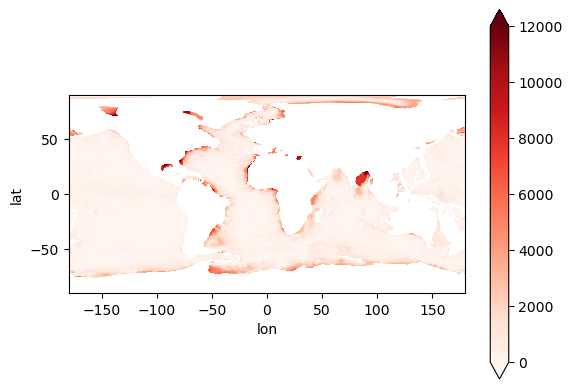

In [37]:
# 删删删
sed_iterxorigin = iter(Y)
sed_origin = [next(sed_iterxorigin) if x else np.nan for x in maskx]
sed_iteryorigin = iter(sed_origin)
sed_origin = [next(sed_iteryorigin) if x else np.nan for x in masky]
sed_origin = np.array(sed_origin).reshape(len(lat), len(lon))
da_origin = xr.DataArray(sed_origin, dims=['lat', 'lon'],
                           coords={'lat': lat,
                                   'lon': lon},)
da_origin.plot(cmap = 'Reds', vmin = 0, vmax = 12000, add_colorbar = True)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

In [34]:
da_re = xr.DataArray(sed_re, dims=['lat', 'lon'],
                           coords={'lat': lat,
                                   'lon': lon},)
da_re

<xarray.DataArray (lat: 721, lon: 1441)> Size: 8MB
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [2328.48037354, 2329.48376465, 2330.23394287, ..., 2313.35405029,
        2320.05897217, 2328.48037354],
       [1864.12658691, 1866.54371704, 1868.21726562, ..., 1859.11825928,
        1861.91713135, 1864.12658691],
       [1873.59875488, 1873.59875488, 1873.59875488, ..., 1873.59875488,
        1873.59875488, 1873.59875488]])
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8 180.0

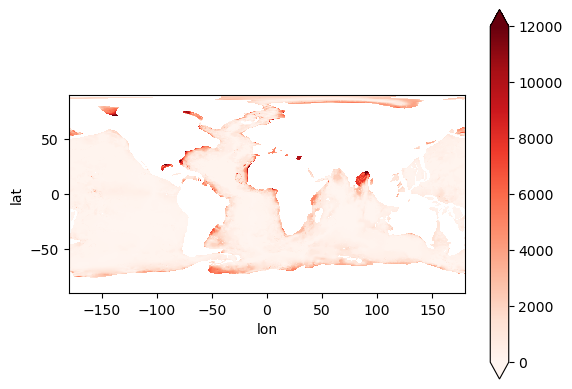

In [35]:
da_re.plot(cmap = 'Reds', vmin = 0, vmax = 12000, add_colorbar = True)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 最近邻

In [6]:
from sklearn.neighbors import NearestNeighbors

In [7]:
# 2. 数据集分割
sed = merged.sed.values.reshape(-1)
var_lat = merged.var_lat.values.reshape(1, -1)
age = merged.age.values.reshape(1, -1)
distance = merged.distance.values.reshape(1, -1)
X = np.vstack((var_lat, age, distance)).T # xlat_age_d
Y = sed # ysed

masky = ~np.isnan(Y)  # 创建掩码，过滤掉 NaN 值
X = X[masky]
Y = Y[masky]
maskx = ~np.isnan(X).any(axis=1)  # 检查每行是否存在 NaN
X = X[maskx]  # 保留没有 NaN 的行
Y = Y[maskx]  # 保持 Y 和 X 行一致
print(np.isnan(Y).sum())  # 检查 Y 中的 NaN 数量
print(np.isnan(X).sum())  # X 中 NaN

0
0


In [8]:
# 使用 KNN 进行检索
k = 3  # 最近邻个数
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X)

NearestNeighbors(n_neighbors=3)

In [9]:
# 逐个目标点预测
distances, indices = knn.kneighbors(X)

sed_knn = []
for i, point in enumerate(X):
    nearest_sed = Y[indices[i]]
    predicted = np.mean(nearest_sed)  # 简单平均作为预测
    sed_knn.append(predicted)

knn_iterx = iter(sed_knn)  # 将sed_knn 转换为迭代器
sed_knn_re = [next(knn_iterx) if x else np.nan for x in maskx]  # 根据 maskx 的值决定是否填充
sed_itery = iter(sed_knn_re)
sed_knn_re = [next(sed_itery) if x else np.nan for x in masky]
sed_knn_re = np.array(sed_knn_re).reshape(len(lat), len(lon))

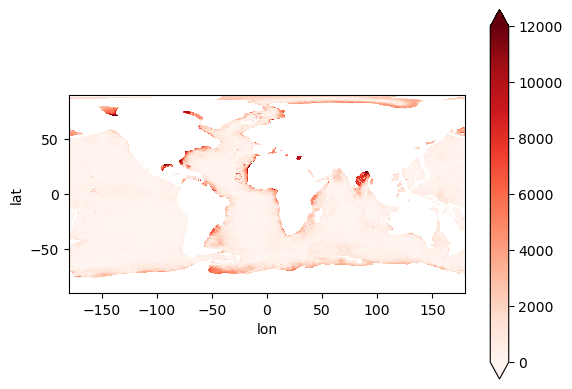

In [10]:
da_knn_re = xr.DataArray(sed_knn_re, dims=['lat', 'lon'],
                           coords={'lat': lat,
                                   'lon': lon},)
da_knn_re.plot(cmap = 'Reds', vmin = 0, vmax = 12000, add_colorbar = True)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 板块重建 计算地质历史sed

In [11]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import gplately
import pygplates
from plate_model_manager import PlateModelManager
from shapely.geometry import MultiPoint, MultiPolygon, Point, Polygon

In [12]:
# 导入板块模型、重建
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")
# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()
# Obtain geometry shapefiles with gdownload
coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, COBs=COBs)

In [24]:
# 设置时间
time = 100 # Ma

for i, continent in enumerate(continents):
    reconstructed_continent = model.reconstruct(continent, time)
    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_continent) # 获取time Ma大陆多边形列表

age_grid = muller2019_model.get_raster("AgeGrids", time = time) # 获取年龄网格
age_griddata = xr.open_dataset(age_grid)
agegrid_interp = age_griddata.interp(lon = lon, lat = lat, method = 'linear') 
age_input = agegrid_interp.z.values.reshape(1, -1) # Dataset

Unrecognized zip data!


In [25]:
# 统一处理 polygons 和 multipolygons
processed_polygons = []
for geom in polygons:  # 假设 polygons 是原始的列表
    if isinstance(geom, Polygon):
        processed_polygons.append(geom)
    elif isinstance(geom, MultiPolygon):
        processed_polygons.extend(list(geom.geoms))  # 提取 MultiPolygon 里的每个 Polygon

maskgrid = np.zeros((len(lon), len(lat)), dtype=bool)
pointls = [Point(x, y) for x in lon for y in lat]
multi_point = MultiPoint(pointls)
multi_polyg = MultiPolygon(processed_polygons)
'''
for i, point in enumerate(tqdm(pointls, desc="Processing points")):
    point_geom = Point(point) # geometry type
    for polygon in polygons:
        if point_geom.intersects(polygon):
            maskgrid[i] = 1
            break
print(maskgrid)
'''

'\nfor i, point in enumerate(tqdm(pointls, desc="Processing points")):\n    point_geom = Point(point) # geometry type\n    for polygon in polygons:\n        if point_geom.intersects(polygon):\n            maskgrid[i] = 1\n            break\nprint(maskgrid)\n'

In [26]:
intersected_points = multi_point.intersection(multi_polyg)
point_coord = []
for point in intersected_points.geoms:
    point_coord.append(point.coords[0])
conti_point = np.array(point_coord)
#plt.scatter(conti_point[:,0],conti_point[:,1], s = 0.05)
#plt.show()

In [27]:
lon_grid, lat_grid = np.meshgrid(lon, lat)
conti_mask = np.zeros((len(lat), len(lon)), dtype=bool)

point_set = set(map(tuple, conti_point))  # 使用 set 提高查询速度

# 遍历网格点，匹配大陆点
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        if (lon_grid[i, j], lat_grid[i, j]) in point_set:
            conti_mask[i, j] = True

d_grid = distance_transform_edt(~conti_mask)
d_input = d_grid.reshape(1, -1)

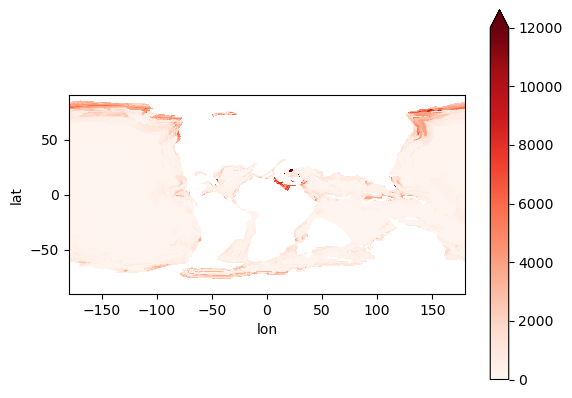

In [28]:
X_input = np.vstack((var_lat, age_input, d_input)).T # xlat_age_d
maskx_input = ~np.isnan(X_input).any(axis=1)  # 检查每行是否存在 NaN
X_input = X_input[maskx_input]  # 保留没有 NaN 的行

# 计算
distances, indices = knn.kneighbors(X_input)
sed_knn = []
for i, point in enumerate(X_input):
    nearest_sed = Y[indices[i]]
    predicted = np.mean(nearest_sed)  
    sed_knn.append(predicted)

knn_iterx = iter(sed_knn)  # 将sed_knn 转换为迭代器
sed_knn_re = [next(knn_iterx) if x else np.nan for x in maskx_input]  # 根据 maskx 的值决定是否填充

sed_knn_re = np.array(sed_knn_re).reshape(len(lat), len(lon))
da_knn_re = xr.DataArray(sed_knn_re, dims=['lat', 'lon'],
                                    coords={'lat': lat,
                                    'lon': lon},)
da_knn_re.plot(cmap = 'Reds', vmin = 0, vmax = 12000, add_colorbar = True)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

In [ ]:
print(vmax)

# SEDIMENT THICKNESS

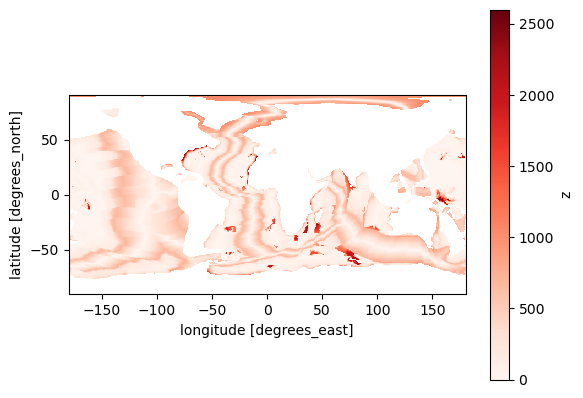

In [18]:
cgrid = muller2019_model.get_raster("SedimentThickness", time=0)
cgrid_data = xr.open_dataset(cgrid)
cgrid_data.z.plot(cmap = 'Reds')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

In [ ]:
time = 0 #Ma
ax2 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=-30))# projection=ccrs.Mollweide(central_longitude = -40)
gplot.time = time

gplot.plot_continents(ax2, facecolor='0.8')
#gplot.plot_continent_ocean_boundaries(ax2, color='0.98')
#gplot.plot_coastlines(ax2, color='0.9')
#gplot.plot_ridges_and_transforms(ax2, color='r')
#gplot.plot_trenches(ax2, color='navy')
#gplot.plot_subduction_teeth(ax2, color='navy')

# Seafloor fabric topology identification variables

#for i, continent in enumerate(continents):
#    reconstructed_continent = model.reconstruct(continent, time)
#    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_continent)
#    ax2.add_geometries(polygons, crs = ccrs.PlateCarree(), facecolor='b')#crs=ccrs.PlateCarree()
#    ax2.set_global()
for i, costline in enumerate(coastlines):
    reconstructed_coastline = model.reconstruct(costline, time)
    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_coastline)
    ax2.add_geometries(polylines, crs = ccrs.PlateCarree(), facecolor='none', edgecolor='r')

plt.show()
print(type(polygons[0]))

In [ ]:
# 提取海岸线的几何形状
coastline_features = [feature.get_geometry() for feature in coastlines if feature.get_geometry() is not None]
# 合并几何图形
all_geometries = pygplates.PolylineOnSphere.merge(coastline_features)

# 设置经纬度范围和分辨率
latitudes = np.linspace(-90, 90, 180)  # 每 1 度一个点
longitudes = np.linspace(-180, 180, 360)
# 创建网格点
grid_lon, grid_lat = np.meshgrid(longitudes, latitudes)
# 将经纬度网格转化为一维数组
grid_points = np.column_stack((grid_lon.ravel(), grid_lat.ravel()))

distances = []
for point_lon, point_lat in grid_points:
    # 创建点的球面几何对象
    point_geometry = pygplates.PointOnSphere(point_lat, point_lon)
    # 计算到目标几何形状的距离（单位：弧度）
    distance = all_geometries.distance(point_geometry)
    # 转换为公里（假设地球半径为 6371 公里）
    distance_km = distance * 6371
    distances.append(distance_km)
# 转换结果为二维数组
distance_grid = np.array(distances).reshape(grid_lon.shape)

plt.figure(figsize=(10, 5))
plt.contourf(grid_lon, grid_lat, distance_grid, levels=100, cmap='viridis')
plt.colorbar(label='Distance to Coastlines (km)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distance to Coastlines')
plt.show()

In [ ]:
time = 150 #Ma

# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude = 0))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkKhaki')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

#for i, continent in enumerate(continents):
#    reconstructed_continent = model.reconstruct(continent, time)
#    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_continent)
#    ax.add_geometries(polygons, crs = ccrs.PlateCarree(), facecolor='b')#crs=ccrs.PlateCarree()
#    ax.set_global()

ax.set_global()
plt.show()

In [ ]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude = 0))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkKhaki')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')
ax.set_global()
plt.show()

In [ ]:
# plot ridges and trenches at 50 Ma

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot()
ax1.scatter(subduction_data[:,0], # longitude
            subduction_data[:,1], # latitude
            color='blue')
ax1.scatter(ridge_data[:,0], # longitude
            ridge_data[:,1], # latitude
            color='red')

plt.show()

In [ ]:
# 滚吧，没用的东西
test_lon = np.broadcast_to(lon, (len(lat), len(lon)))
test_lon = test_lon.reshape(-1)
test_lon = test_lon[masky]
test_lon = test_lon[maskx]
test_lat = X[..., 0]

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(test_lon, test_lat, s = 1, c = sed_test)
#ax1.set(xlim=(-180, 180), ylim=(-90, 90))
ax2.scatter(test_lon, test_lat, s = 1, c = Y)
#ax2.set(xlim=(-180, 180), ylim=(-90, 90))
plt.show()

In [ ]:
!where python

In [ ]:
print(pygplates.__version__)

In [ ]:
x1d = np.linspace(-2*np.pi, 2*np.pi, 100)
y1d = np.linspace(-np.pi, np.pi, 50)
xx, yy = np.meshgrid(x1d, y1d)
x_sm, y_sm = xx[:10, :10], yy[:10, :10]
print(x_sm.shape)